In [ ]:
from datasets import load_dataset

ds = load_dataset("open-r1/OpenR1-Math-220k", "default")

Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

In [13]:
# get 10000 problems for each problem type ["Algebra", "Geometry", "Number Theory"]

promblems_by_type = {}
for problem_type in ["Algebra", "Geometry", "Number Theory"]:
    problems = ds["train"].filter(lambda x: x["problem_type"] == problem_type)
    promblems_by_type[problem_type] = problems.select(range(10000))['problem']

In [14]:
# Filter excesivly long problems

for problem_type in ["Algebra", "Geometry", "Number Theory"]:
    promblems_by_type[problem_type] = [p for p in promblems_by_type[problem_type] if len(p) < 300]

In [15]:
len(promblems_by_type["Algebra"]), len(promblems_by_type["Geometry"]), len(promblems_by_type["Number Theory"])

(7455, 5804, 7678)

In [16]:
all_problems = [p for p in promblems_by_type["Algebra"] + promblems_by_type["Geometry"] + promblems_by_type["Number Theory"]]

In [17]:
import numpy as np

class Agent:
    def __init__(self, domains, init_success_rates=None, learning_rates=None, proficient_threshold=0.7):
        """
        Initialize an agent with hidden true success rates for each problem domain.
        
        Parameters:
        - domains: List of problem types (e.g., ["Algebra", "Geometry", "Number Theory"]).
        - init_success_rates: Optional dict mapping each domain to its initial success rate.
                              Default is 0.1 (i.e. 10%) for each.
        - learning_rates:     Optional dict mapping each domain to a learning rate.
                              Later (harder) domains might use a slower learning rate.
        - proficient_threshold: The hidden success rate threshold at which the domain 
                                is considered “mastered” and the agent moves on.
        """
        self.domains = domains
        # Initialize each domain’s hidden success rate to a starting value if not provided.
        if init_success_rates is None:
            init_success_rates = {domain: 0.1 for domain in domains}
        # Initialize learning rates (perhaps the agent learns Algebra fastest and Number Theory slowest)
        if learning_rates is None:
            learning_rates = {"Algebra": 0.004, "Geometry": 0.002, "Number Theory": 0.0005}
            # ensure every domain is covered
            for d in domains:
                if d not in learning_rates:
                    learning_rates[d] = 0.01
        self.hidden_success_rates = init_success_rates  # these remain hidden
        self.learning_rates = learning_rates
        self.proficient_threshold = proficient_threshold

    def attempt_problem(self, domain):
        """
        Attempt a problem of a given domain.
        
        Returns:
        - 1 if the attempt is successful.
        - 0 if the attempt fails.
        
        The outcome is decided probabilistically based on the current hidden success rate
        for the domain. The hidden success rate is then updated to simulate learning.
        """
        # Get current hidden success rate for the domain.
        success_prob = self.hidden_success_rates[domain]
        # Decide outcome: success (1) with probability success_prob, otherwise failure (0)
        outcome = 1 if np.random.rand() < success_prob else 0

        # Simulate a learning update:
        # If the agent is successful, boost its hidden success rate more.
        # If it fails, boost it only slightly (to simulate that even failures provide some learning signal).
        if outcome:
            update = self.learning_rates[domain] * (1 - success_prob)
        else:
            update = self.learning_rates[domain] * 0.1 * (1 - success_prob)
            
        # Update the hidden success rate while ensuring it never exceeds 1.0.
        self.hidden_success_rates[domain] = min(success_prob + update, 1.0)
        return outcome

In [18]:
from tqdm import tqdm
import matplotlib.pyplot as plt

goals = [all_problems[np.random.randint(0, len(all_problems))] for _ in range(20000)]
successes = []
true_sr = {"Algebra": [], "Geometry": [], "Number Theory": []}
domains = ["Algebra", "Geometry", "Number Theory"]
agent = Agent(domains)
for g in tqdm(goals):
    domain = "Algebra" if g in promblems_by_type["Algebra"] else "Geometry" if g in promblems_by_type["Geometry"] else "Number Theory"
    outcome = agent.attempt_problem(domain)
    successes.append(outcome)
    for d in domains:
        true_sr[d].append(agent.hidden_success_rates[d])

100%|██████████| 20000/20000 [00:00<00:00, 20669.16it/s]


In [19]:
len(true_sr["Algebra"])

20000

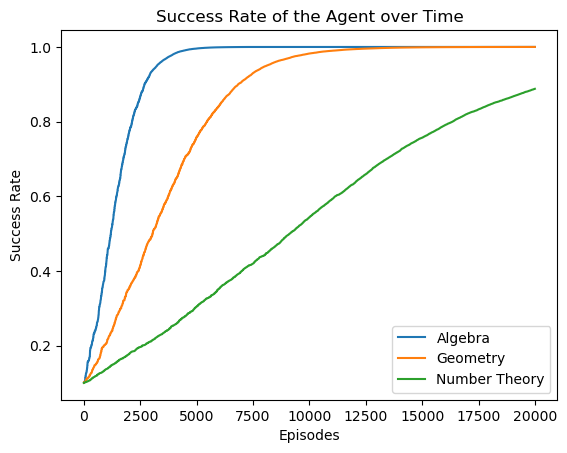

In [30]:
plt.plot(true_sr["Algebra"], label="Algebra")
plt.plot(true_sr["Geometry"], label="Geometry")
plt.plot(true_sr["Number Theory"], label="Number Theory")
plt.xlabel("Episodes")
plt.ylabel("Success Rate")
plt.title("Success Rate of the Agent over Time")
plt.legend()
plt.show()

/home/loris/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/loris/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


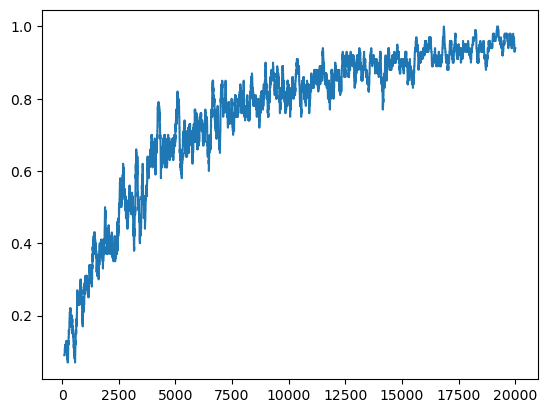

In [21]:
sr = [np.mean(successes[i-100:i]) for i in range(len(successes))]
plt.plot(sr)
plt.show()

In [22]:
import pickle
to_save = {"promblems_by_type": promblems_by_type, "goals": goals, "successes": successes, "true_sr": true_sr}
with open("to_save.pkl", "wb") as f:
    pickle.dump(to_save, f)